# Film Analysis
This is a project for the IUM course of the computer science degree course.  
This project wants to analyze some data like the actors, the languages, the crew exc. of different films. 
## First steps
In the beginning we check the type of the data of the dataframes used for the analysis, later we will clean the data so that we can start the analysis of the data in order to find some correlation between the data or to debunking beliefs  
Possibili analisi: mi aspetto che i film con candidazioni all'oscar abbiano un rating più alto. I film prodotti in america ed europa hanno un rating più alto. Qual è il tipo di film con rating più alto, quindi quello che piace di più. In che lingua sono i film con rating più alti (mi aspetto l'inglese su tutti). Quali sono i generi con rating più alto. In che paese vengono prodotti più film di genere drammatico (USA, cina, india, giappone). Quale studio produce più film e che rating hanno i film prodotti. Raggruppando i film ogni decina di anni, quali sono stati i generi più amati in ogni decade

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
actors = pd.read_csv('data/actors.csv')
countries = pd.read_csv('data/countries.csv')
crew = pd.read_csv('data/crew.csv')
genres = pd.read_csv('data/genres.csv')
languages = pd.read_csv('data/languages.csv')
movies = pd.read_csv('data/movies.csv') #contiene anche film che devono ancora uscire e che quindi non hanno ancora un rating
posters = pd.read_csv('data/posters.csv') # inutile perché contiene solo i link di posters dei film 
releases = pd.read_csv('data/releases.csv')
studios = pd.read_csv('data/studios.csv')
oscars = pd.read_csv('data/the_oscar_awards.csv')
themes = pd.read_csv('data/themes.csv') # contiene solo la "trama" del film

In [28]:
actors['name'] = actors['name'].astype('string')
actors['role'] = actors['role'].astype('string')
countries['country'] = countries['country'].astype('string')
crew['name'] = crew['name'].astype('string')
crew['role'] = crew['role'].astype('string')
genres['genre'] = genres['genre'].astype('string')
languages['language'] = languages['language'].astype('string')
languages['type'] = languages['type'].astype('string')
movies['name'] = movies['name'].astype('string')
movies['date'] = pd.to_datetime(movies['date'], format='%Y')
releases['country'] = releases['country'].astype('string')
releases['type'] = releases['type'].astype('string')
releases['date'] = pd.to_datetime(releases['date'], format='%Y-%m-%d')
studios['studio'] = studios['studio'].astype('string')
oscars['category'] = oscars['category'].astype('string')
oscars['name'] = oscars['name'].astype('string')
oscars['film'] = oscars['film'].astype('string')
themes['theme'] = themes['theme'].astype('string')

In [29]:
#movies['date'].unique()

In [30]:
movies[movies['id'].duplicated()] #non contiene duplicati
movies.set_index('id', inplace=True)

In [31]:
crew[crew.isna().any(axis=1)]

,id,role,name
4562126,1859397,Writer,<NA>


In [32]:
dataframes = {'df1': actors, 'df2': countries, 'df3': crew, 'df4': genres, 'df5': languages, 'df6': movies,
              'df7': releases, 'df8': studios, 'df9': oscars, 'df10': themes}

for name, df in dataframes.items():
    print(f"{name} columns:")
    print(list(df.columns))
    print()

df1 columns:
['id', 'name', 'role']

df2 columns:
['id', 'country']

df3 columns:
['id', 'role', 'name']

df4 columns:
['id', 'genre']

df5 columns:
['id', 'type', 'language']

df6 columns:
['name', 'date', 'tagline', 'description', 'minute', 'rating']

df7 columns:
['id', 'country', 'date', 'type', 'rating']

df8 columns:
['id', 'studio']

df9 columns:
['year_film', 'year_ceremony', 'ceremony', 'category', 'name', 'film', 'winner']

df10 columns:
['id', 'theme']



In [33]:
movies.loc[(movies['date'].dt.year < 2025) & (movies['date'].dt.year > 2023)]

,name,date,tagline,description,minute,rating
id,,,,,,
1000028,Dune: Part Two,2024-01-01,Long live the fighters.,Follow the mythic journey of Paul Atreides as ...,167.0,4.47
1000075,Challengers,2024-01-01,Her game. Her rules.,Tennis player turned coach Tashi has taken her...,132.0,4.06
1000358,Civil War,2024-01-01,Welcome to the frontline.,"In the near future, a group of war journalists...",109.0,3.65
1000464,The Fall Guy,2024-01-01,Fall hard.,"Fresh off an almost career-ending accident, st...",126.0,3.50
1000474,Mean Girls,2024-01-01,Plastic is forever.,New student Cady Heron is welcomed into the to...,113.0,2.69
...,...,...,...,...,...,...
1940164,Kuuk Aah?,2024-01-01,NaN,"While cooking, Anjali realizes that they have ...",29.0,NaN
1940165,You Expect Me to Believe That?,2024-01-01,NaN,ARE YOU TIRED OF SCIENTISTS TELLING US MEAN BA...,6.0,NaN
1940166,Comin' Up Short,2024-01-01,The true story of Shorty from Da Lench Mob,"From being a ruthless gang banger, to protecti...",60.0,NaN


# Highest Rating Films per Country
This analysis aims to visualize the average rating of films produced by countries with at least 1,500 films.  
Since the United States produces the most films overall and is the most renowned for its film production, it is expected to have the highest average rating.  
The majority of award-winning films are produced in America, so it's natural to assume that the average rating for these films would also be higher than elsewhere.  
However, this isn't the case; among all the countries that have produced at least 1,500 films, the one with the highest average rating is Japan, followed by France and England (America isn't even on the podium). This holds true even if we raise the minimum threshold of films to 5,000, America remains outside the top three.  
The number of films produced by every nation is shown by the piechart where the countries wth less than 850 films are grouped in the label "Others"

In [34]:
country_films = pd.merge(movies, countries, left_on='id', right_on='id', how='left')

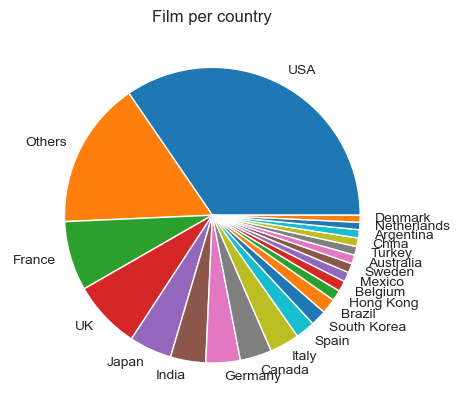

In [35]:
country_films = country_films[~country_films['rating'].isna()]
counts_of_films = country_films['country'].value_counts()
valid_countries = counts_of_films[counts_of_films >= 850].index

country_films['country_grouped'] = country_films['country'].where(
    country_films['country'].isin(valid_countries),
    other='Others'
)

counts = country_films['country_grouped'].value_counts()
counts.plot(kind='pie')
plt.title('Film per country')
plt.ylabel(' ')
plt.show()

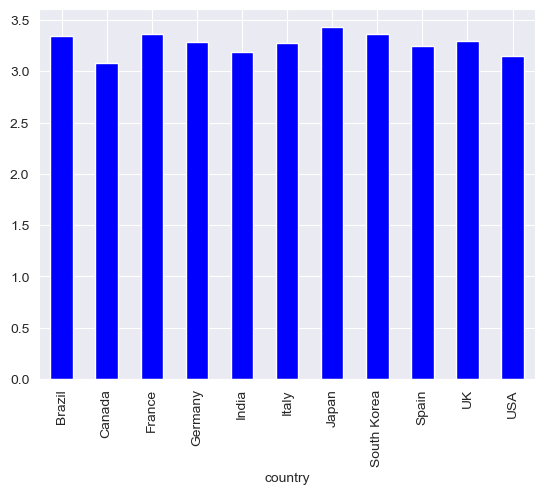

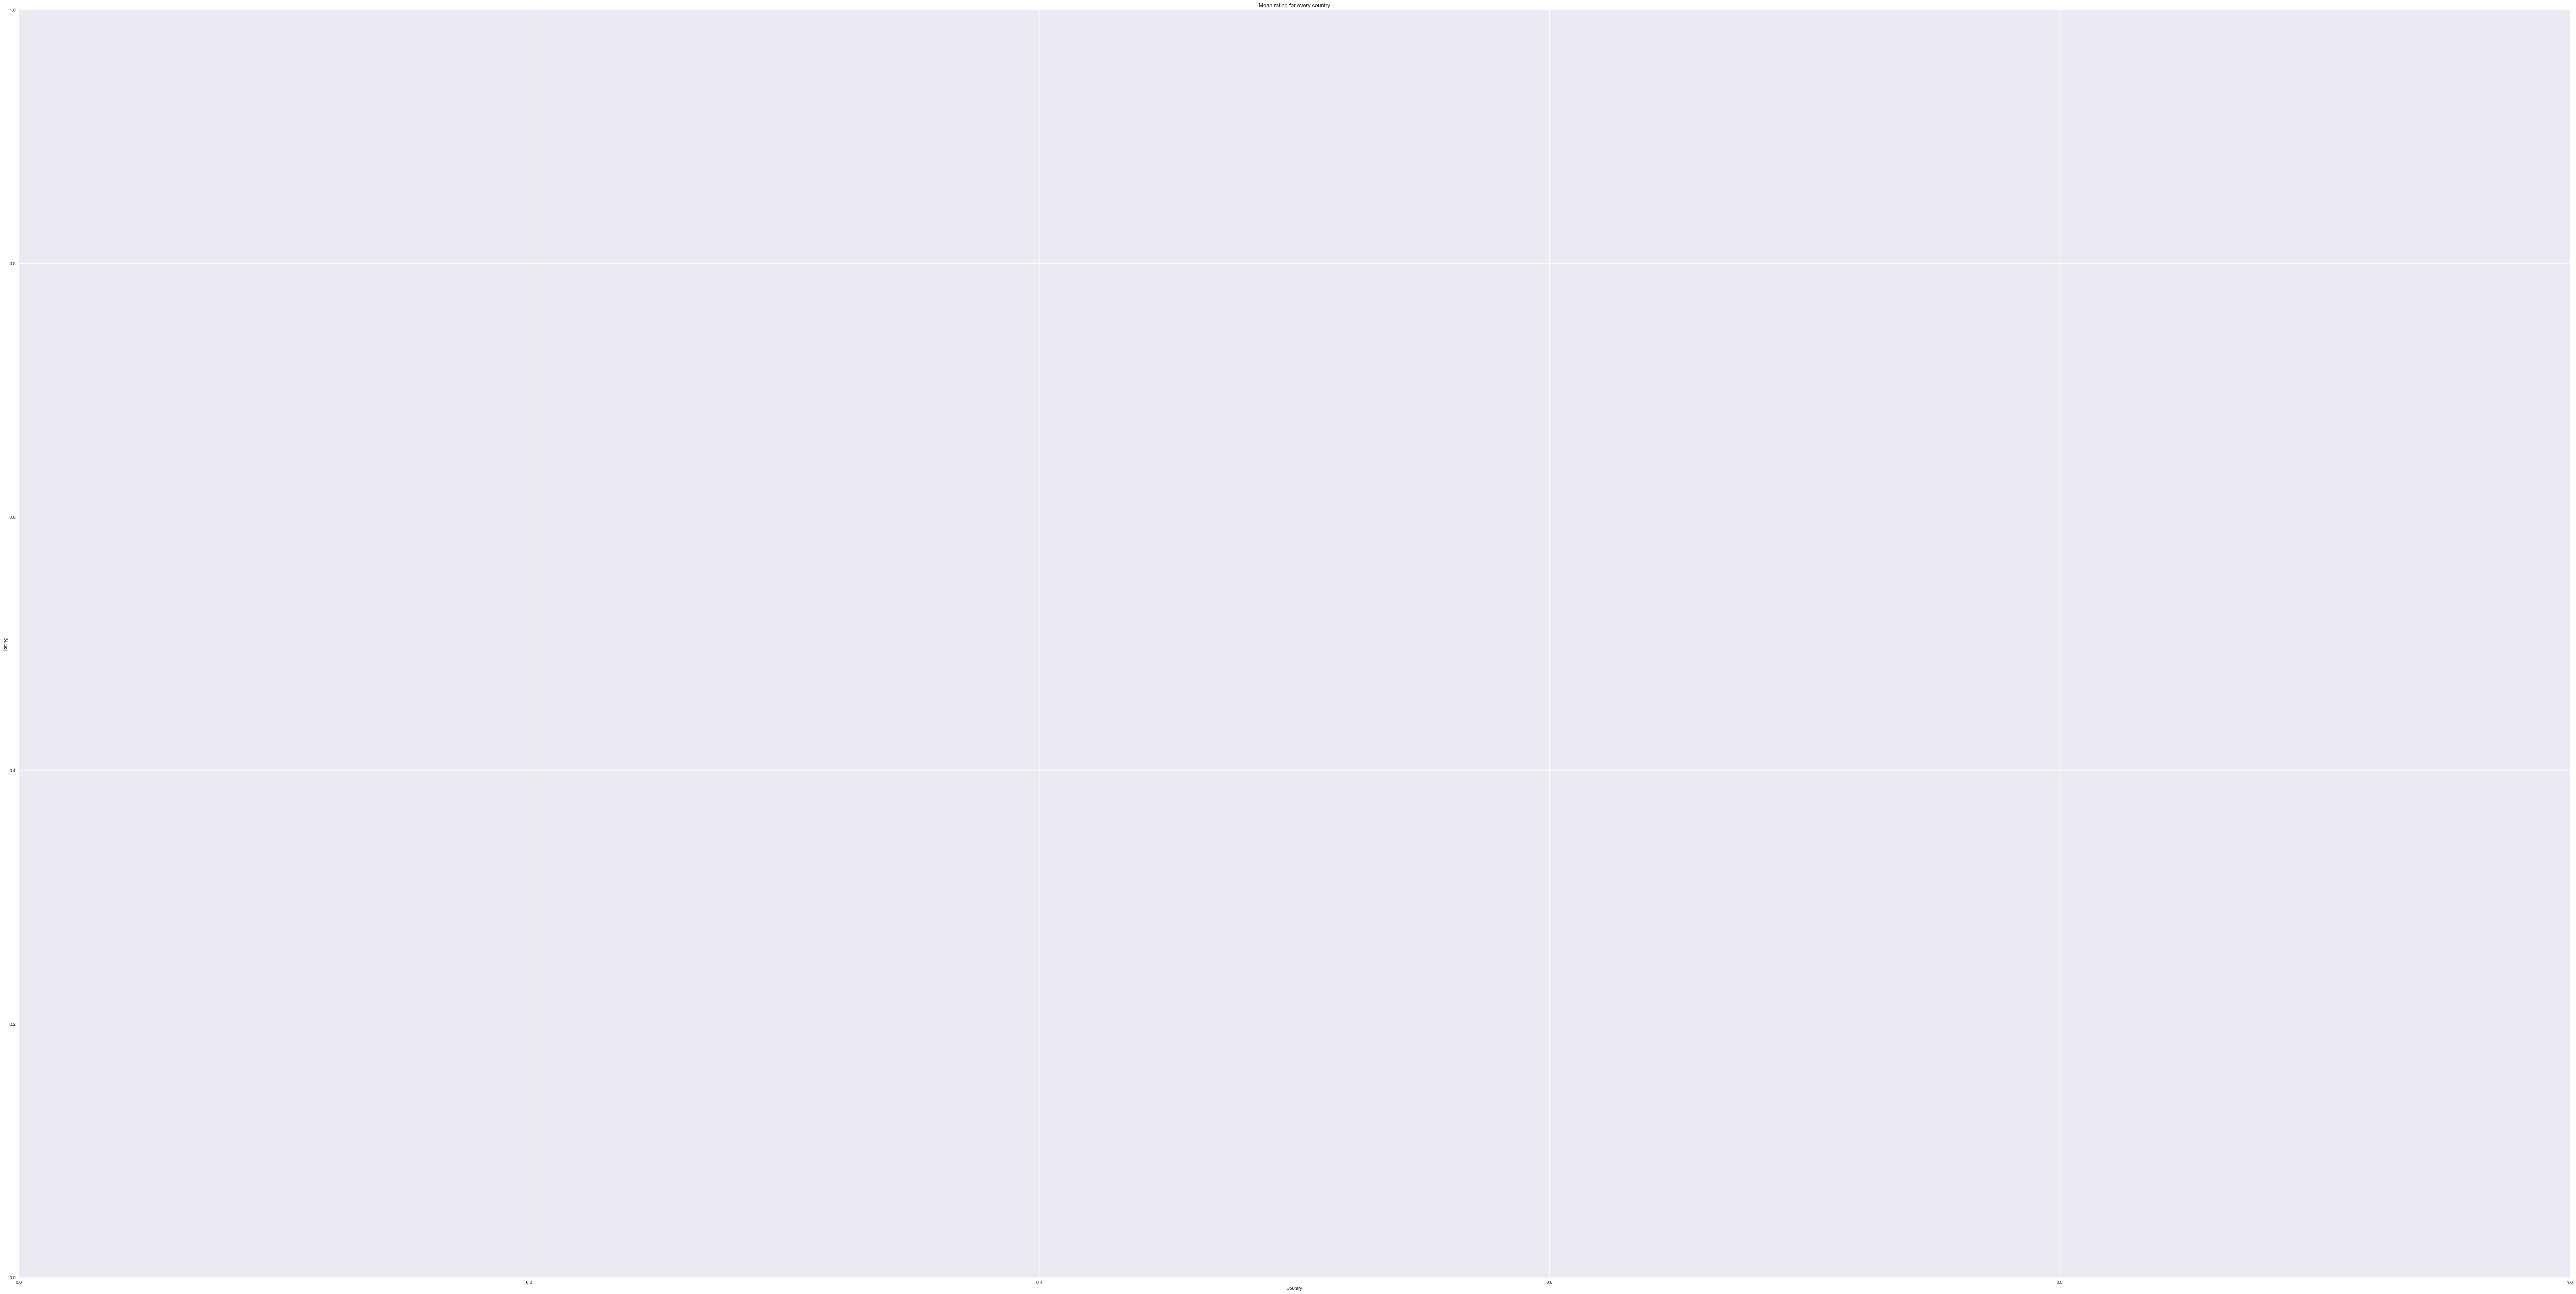

In [36]:
country_with1500_films = counts_of_films[counts_of_films > 1500].index
country_top1500 = country_films[country_films['country'].isin(country_with1500_films)]
avg_rating_by_country = country_top1500.groupby('country')['rating'].mean()
avg_rating_by_country = avg_rating_by_country[avg_rating_by_country > 2.5]
avg_rating_by_country.plot(kind='bar', color='blue')
plt.xticks(rotation=90)
plt.figure(figsize=(100, 50))
plt.title('Mean rating for every country')
plt.xlabel('Country')
plt.ylabel('Rating')
plt.show()

# TrendLine of the production of films by year
For this analysis, we only consider films produced up to 2023 because in the "movie" dataset, some films produced in 2024 have a rating while others do not.  
This suggests that some films have not yet been released and will not be included in the analysis because it is uncertain whether they will be produced, just as the release year is uncertain; many films are often postponed  
As we can expect the production of the films from 1874 has exponentially increased thanks to some innovations in the cinematography world, for example, in 1996, high definition was introduced, an international agreement on resolution and format standards.  
Another innovation occurred in 1999 when the first non-experimental film was released with large portions shot with high-definition cameras. Computer editing also made film production faster

In [37]:
films_by_year = pd.merge(movies, countries, left_on='id', right_on='id', how='left')
# extract the release year from every film
films_by_year['release_year'] = films_by_year['date'].dt.year
# eliminate the duplicated films with same release year
films_by_year.drop_duplicates(subset=['id', 'release_year'] ,inplace=True)
films_by_year = films_by_year[films_by_year['release_year'] < 2024]
films_by_year['release_year'].describe()

count    830290.000000
mean       1997.926545
std          27.574031
min        1874.000000
25%        1985.000000
50%        2009.000000
75%        2018.000000
max        2023.000000
Name: release_year, dtype: float64

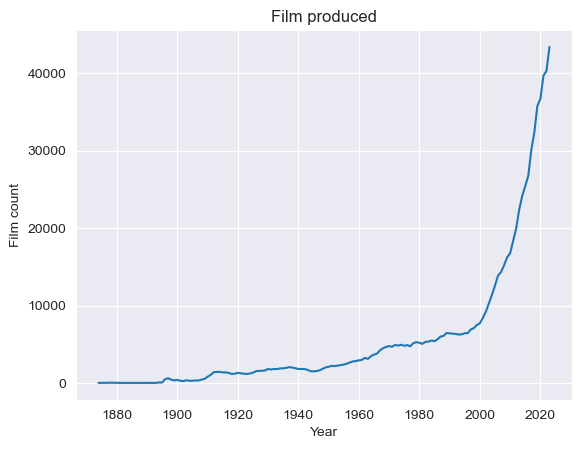

In [38]:
trend = films_by_year.groupby('release_year').size().reset_index(name = 'film_count')
# build the trendLine
sns.lineplot(data=trend, x='release_year', y='film_count')
plt.title('Film produced')
plt.xlabel('Year')
plt.ylabel('Film count')
plt.grid(True)
plt.show()

In [39]:
#~

# Rating VS Duration

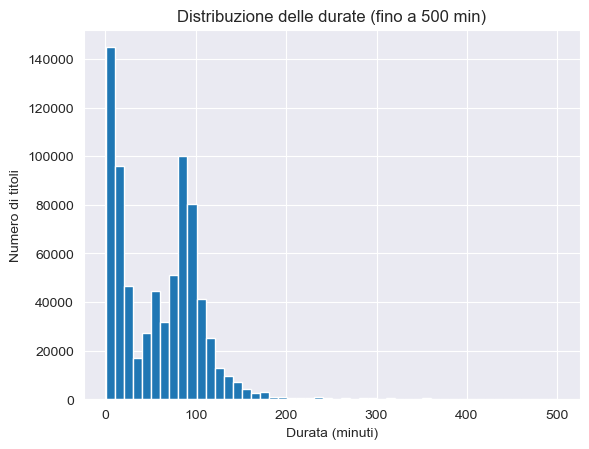

In [61]:
movies_filtered = movies[movies['minute'] <= 500]# o anche 300
movies_filtered = movies_filtered[movies_filtered['minute'].notna()]
plt.hist(movies_filtered['minute'], bins=50)
plt.xlabel('Durata (minuti)')
plt.ylabel('Numero di titoli')
plt.title('Distribuzione delle durate (fino a 500 min)')
plt.show()

In [64]:
from utils.functions import classifica_durata
movies_with_types = movies
movies_with_types['type_of_movie'] = movies_with_types.apply(classifica_durata, axis=1)
movies_with_types.head(50)

,name,date,tagline,description,minute,rating,type_of_movie
id,,,,,,,
1000001,Barbie,2023-01-01,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.86,Film
1000002,Parasite,2019-01-01,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.56,Film
1000003,Everything Everywhere All at Once,2022-01-01,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.30,Film
1000004,Fight Club,1999-01-01,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27,Film
1000005,La La Land,2016-01-01,Here's to the fools who dream.,"Mia, an aspiring actress, serves lattes to mov...",129.0,4.09,Film
1000006,Oppenheimer,2023-01-01,The world forever changes.,The story of J. Robert Oppenheimer's role in t...,181.0,4.23,Film
1000007,Interstellar,2014-01-01,Mankind was born on Earth. It was never meant ...,The adventures of a group of explorers who mak...,169.0,4.35,Film
1000008,Joker,2019-01-01,Put on a happy face.,"During the 1980s, a failed stand-up comedian i...",122.0,3.85,Film
1000009,Dune,2021-01-01,"Beyond fear, destiny awaits.","Paul Atreides, a brilliant and gifted young ma...",155.0,3.90,Film


In [66]:
movies_with_types = movies_with_types[(movies_with_types['rating'].notna()) & (movies['minute'].notna())]